In [1]:
from DecisionTreeClassifier import DTC
import pandas as pd
import numpy as np
from collections import Counter
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
import multiprocessing
spark_driver_memory = "10g"
spark_executor_memory = "6g"

In [2]:
class RandomForest():
    def __init__(self, n_estimators = 100, features_col = "feature", min_sample_split = 2, label_col = "label", criterion = "gini", max_depth = None, max_features = "sqrt", bootstrap = False, random_state = None, max_thresholds = None, verbose = 0):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.verbose = verbose
        self.trained_trees = []
        self.features_col = features_col
        self.label_col = label_col
        self.max_thresholds = max_thresholds
        self.min_sample_split = min_sample_split 

        if self.random_state is not None:
            self.random_generator = np.random.RandomState(self.random_state)
        else:
            self.random_generator = None

    def __create_tree(self, partition_id, iterator):
        data = list(iterator)
        columns = list(data[0].__dict__.items())[0][1]
        df = pd.DataFrame(data, columns=columns).drop('id', axis=1)
        label_array = np.array(df[self.label_col])

        if self.random_generator:
            tree_random_state = self.random_state + partition_id
        else:
            tree_random_state = None

        clf = DTC(max_depth=self.max_depth, criterion=self.criterion, max_features=self.max_features,
                  random_state=tree_random_state, max_thresholds=self.max_thresholds,
                  class_weights={0: 1, 1: 1 / (np.sum(label_array) / len(label_array))}, min_sample_split = self.min_sample_split)

        clf.fit(np.array([x.toArray().tolist() for x in np.array(df[self.features_col])]), label_array)

        yield clf


    def fit(self, X):
        df = X.select(self.label_col, self.features_col)
        
        df_train = df

        if(self.bootstrap):
            df_train = df_train.sample(withReplacement=True, fraction=1.0, seed=self.random_state)    
        
        df = df_train.withColumn("id", monotonically_increasing_id())   

        df = df.repartition(self.n_estimators, "id")

        models = df.rdd.mapPartitionsWithIndex(self.__create_tree)
        self.trained_trees = models.collect()

    def __predict(self, index, iterator):
        data = list(iterator)
        columns = list(data[0].__dict__.items())[0][1]
        df = pd.DataFrame(data, columns=columns)
        predictions = []
        ids_table = np.array(df['id'])
        for model in self.trained_trees:
            predictions.append(model.predict(np.array(df.iloc[:,:-1])))
        
        n = len(predictions[0])

        most_frequent = []

        # iterate over the positions in the arrays
        for i in range(n):
            # create a list of values at position i
            values = [a[i] for a in predictions]
            # count the frequency of each value
            counter = Counter(values)
            # get the most common value and its frequency
            most_common = counter.most_common(1)[0]
            # add the most common value to the new array
            most_frequent.append(most_common[0])

        returning = list(zip(ids_table, most_frequent))

        
        yield returning
    

    def predict(self, X):
        df = X.withColumn("id", monotonically_increasing_id()).repartition(self.n_estimators, "id")
        models = df.rdd.mapPartitionsWithIndex(lambda index, iterator: self.__predict(index, iterator))
        collapsed_list = []
        for sublist in models.collect():
            collapsed_list.extend(sublist)
        sorted_list = [x[1] for x in sorted(collapsed_list, key=lambda x: x[0])]
        return sorted_list

In [3]:
if 'spark' in vars():
  spark.stop()

# Count available cores
cores = multiprocessing.cpu_count()
# In this case the amount of executors will be equal to the amount of cores
instances = cores

spark = SparkSession.builder \
          .appName("MoneyLaundering") \
          .config("spark.driver.memory", spark_driver_memory) \
          .config("spark.executor.memory", spark_executor_memory) \
          .getOrCreate()

spark.sparkContext.setLogLevel("OFF")
sc = spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/11 09:34:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
schema = StructType([
    StructField('timestamp', StringType(), True),
    StructField('from_bank', IntegerType(), True),
    StructField('from_account', StringType(), True),
    StructField('to_bank', IntegerType(), True),
    StructField('to_account', StringType(), True),
    StructField('amount_received', FloatType(), True),
    StructField('receiving_currency', StringType(), True),
    StructField('amount_paid', FloatType(), True),
    StructField('payment_currency', StringType(), True),
    StructField('payment_format', StringType(), True),
    StructField('is_laundering', IntegerType(), True)])



spark_df = spark.read.csv("./preprocessed_data/preprocessed_data_small.csv", header = True)
spark_df = spark_df.drop('timestamp')
columns_to_cast = spark_df.columns

for column in columns_to_cast:
    spark_df = spark_df.withColumn(column, col(column).cast("integer"))


In [ ]:
spark_df = spark_df.fillna(0)

In [ ]:
# Split the DataFrame into train and test sets
train_df, test_df = spark_df.randomSplit([0.7, 0.3], seed=42)

In [ ]:
validation_df = spark.read.parquet('./preprocessed_data/df.validation')
validation_df.show()

In [ ]:
train_df.show()

In [4]:
train_df = spark.read.parquet('./preprocessed_data/train_small')
train_df = train_df.drop('avg_previous_amount').drop('amount_variation')
test_df = spark.read.parquet('./preprocessed_data/test_small')
test_df = test_df.drop('avg_previous_amount').drop('amount_variation')

In [6]:
y_test=np.array(test_df.select('is_laundering').collect()).squeeze()

In [15]:
from pyspark.ml.feature import VectorAssembler
rf = RandomForest(label_col="is_laundering", features_col="features", bootstrap=True, max_depth= 10, min_sample_split= 14, criterion= "shannon", max_features= "sqrt", max_thresholds= 15,   n_estimators=5, random_state = 0)
assembler = VectorAssembler(inputCols=train_df.drop("is_laundering").columns, outputCol="features")
train = assembler.transform(train_df)
test = assembler.transform(test_df)
rf.fit(train)

In [16]:
rf.n_estimators = 100

In [17]:
y_pred = rf.predict(test_df.drop("is_laundering"))

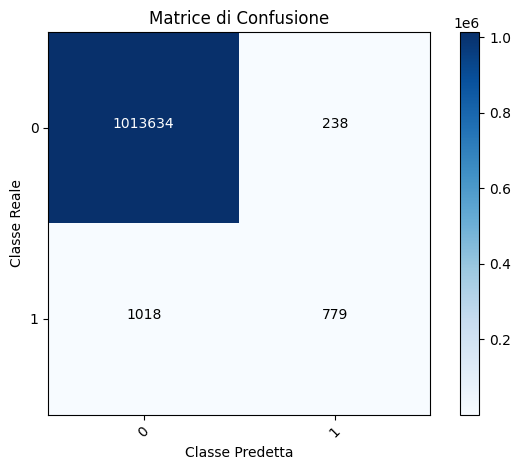

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 56284)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/fabio/spark-3.2.4-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/home/fabio/spark-3.2.4-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/home/fabio/spark-3.2.4-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/accumulators.py", line 239, i

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcola la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Etichette delle classi (sostituisci con i tuoi nomi di classi reali se necessario)
class_names = ['0', '1']

# Crea il grafico della matrice di confusione
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice di Confusione')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Aggiungi i valori delle celle nella matrice
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Classe Predetta')
plt.ylabel('Classe Reale')
plt.tight_layout()
plt.show()
